# Análisis del menú de Burger King

## Datasets utilizados:
- [Burger King Menu Nutrition Data](https://www.kaggle.com/datasets/mattop/burger-king-menu-nutrition-data/suggestions?status=pending&yourSuggestions=true)
- [Fast Food Joint Nutrition Values Dataset](https://www.kaggle.com/datasets/rakkesharv/fast-food-joint-nutrition-values-dataset?select=Nutrition_Value_Dataset.csv)
- [Fast Food Chains - Nutrition Values](https://www.kaggle.com/datasets/denizyigit/fast-food-chains-nutrition-values)

# Carga de datasets

Se establecen variables de las direcciones de los datasets en formato csv y se cargan los datasets necesarios para iniciar el análisis. También se muestra el schema de cada dataset

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

sns.set_theme(style="darkgrid")

In [4]:
# Como no puedo extraer los datasets de Kaggle vía código en colab, los descargué e incluí en mi propio repo de github
BK_MENU_DATASET_URL = 'https://ipy849.github.io/burger-king-BI/burger-king-menu.csv'
NUTRITIONAL_VALUE_FAST_FOOD_URL = 'https://ipy849.github.io/burger-king-BI/fast_food_nutrition_values.csv'
BK_MD_VALUE_FAST_FOOD_URL = 'https://ipy849.github.io/burger-king-BI/fast_food_franchise_Nutrition_Value_Dataset.csv'

# OPTIONS
SIMILITUDE_RATIO = 0.8
DB_SCAN_EPS = 140
DB_SCAN_MIN_SAMPLES = 3

In [5]:
print_section = lambda label: print(5*"-" + label + 5*"-")

bk_dataset = pd.read_csv(BK_MENU_DATASET_URL, header=0)
print_section("Burger King Menu schema")
print(bk_dataset.dtypes, "\n")

ff_nutritional_val_dataset = pd.read_csv(NUTRITIONAL_VALUE_FAST_FOOD_URL, sep=";")
print_section("Fast Food Nutrition Values schema")
print(ff_nutritional_val_dataset.dtypes, "\n")

ff_franchise_dataset = pd.read_csv(BK_MD_VALUE_FAST_FOOD_URL)
print_section("Fast Food Franchise Nutrition Values schema")
print(ff_franchise_dataset.dtypes, "\n")

-----Burger King Menu schema-----
Item                  object
Category              object
Calories             float64
Fat Calories         float64
Fat (g)              float64
Saturated Fat (g)    float64
Trans Fat (g)        float64
Cholesterol (mg)     float64
Sodium (mg)          float64
Total Carb (g)       float64
Dietary Fiber (g)    float64
Sugars (g)           float64
Protein (g)          float64
Weight Watchers      float64
dtype: object 

-----Fast Food Nutrition Values schema-----
Chain                object
Item                 object
Type                 object
Serving Size (g)     object
Calories              int64
Calories from fat     int64
Total Fat (g)        object
Saturated Fat (g)    object
Trans Fat (g)        object
Chol (mg)             int64
Sodium (mg)           int64
Total Carb (g)        int64
Dietary Fiber (g)     int64
Total Sugar (g)       int64
Protein (g)           int64
dtype: object 

-----Fast Food Franchise Nutrition Values schema-----
Company   

# Limpieza de datos
- Se eliminan todas las filas donde falte información o no se haya podido parsear bien, esta decisión se tomó ya que cada dataset podrá complementar la información de los otros, pues tenemos tres fuentes de verdad
- Se van a explorar los tres datasets para solo quedar con información de Burger King
- Se le da formato a los datos
- Se unen los dataset según los criterios explicados más adelante

### Limpiando información innecesaria y mostrando sus generalidades


In [6]:
# Limpiar info
bk_dataset = bk_dataset.drop(['Weight Watchers', 'Category'], axis=1).dropna(how="any")
bk_dataset = bk_dataset.sort_values(by=['Item'])
bk_dataset.head()

,Item,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g)
67,American Cheese (slice),40.0,30.0,3.5,2.0,0.0,10.0,180.0,1.0,0.0,0.0,2.0
26,BBQ Bacon Crispy Chicken Sandwich,790.0,440.0,49.0,10.0,0.5,80.0,1630.0,60.0,2.0,13.0,28.0
39,BIG FISH Sandwich,510.0,250.0,28.0,4.5,0.0,30.0,1180.0,51.0,2.0,7.0,16.0
59,BK™ Ultimate Breakfast Platter,930.0,390.0,44.0,11.0,0.0,390.0,2230.0,110.0,4.0,40.0,24.0
25,Bacon & Cheese Crispy Chicken Sandwich,800.0,460.0,52.0,13.0,1.0,95.0,1650.0,55.0,2.0,8.0,30.0


In [7]:
# Eliminar información innecesaria
ff_nutritional_val_dataset = ff_nutritional_val_dataset.loc[
    ff_nutritional_val_dataset['Chain'] == 'Burger King'
].drop(['Chain', 'Type'], axis=1).dropna(how="any")

# Limpiar info
field_to_float = ['Serving Size (g)', 'Total Fat (g)', 'Saturated Fat (g)', 'Trans Fat (g)']
for field in field_to_float:
    ff_nutritional_val_dataset[field] = ff_nutritional_val_dataset[field].str.replace(',', '.')
    ff_nutritional_val_dataset.loc[ff_nutritional_val_dataset[field].str.contains('-'), field] = 0;
    ff_nutritional_val_dataset[field] = ff_nutritional_val_dataset[field].astype(float)

ff_nutritional_val_dataset = ff_nutritional_val_dataset.sort_values(by=['Item'])
ff_nutritional_val_dataset.describe()

,Serving Size (g),Calories,Calories from fat,Total Fat (g),Saturated Fat (g),Trans Fat (g),Chol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Total Sugar (g),Protein (g)
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,162.085714,438.857143,235.428571,26.185714,8.242857,0.466667,78.142857,833.142857,34.676190,1.828571,8.200000,16.742857
std,106.243019,290.832076,177.662594,19.783839,7.598746,1.005434,93.225474,616.857832,19.929441,1.783779,8.889709,16.589517
min,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,89.000000,230.000000,100.000000,11.000000,2.500000,0.000000,10.000000,310.000000,26.000000,1.000000,2.000000,4.000000
50%,142.000000,370.000000,190.000000,21.000000,6.000000,0.000000,35.000000,740.000000,31.000000,1.000000,6.000000,12.000000
75%,225.000000,630.000000,340.000000,40.000000,12.000000,0.500000,115.000000,1310.000000,49.000000,2.000000,11.000000,25.000000
max,461.000000,1220.000000,750.000000,84.000000,33.000000,4.500000,390.000000,2840.000000,110.000000,9.000000,43.000000,71.000000


In [8]:
# Eliminar información innecesaria
ff_franchise_dataset = ff_franchise_dataset.loc[
    ff_franchise_dataset['Company'] == 'Burger King'
].drop(['Company', 'Category', 'Per Serve Size'], axis=1).dropna(how="any")

# Limpiar info
ff_franchise_dataset = ff_franchise_dataset.sort_values(by=['Product'])
ff_franchise_dataset.describe()

,Energy (kCal),Carbohydrates (g),Protein (g),Fiber (g),Sugar (g),Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg)
count,41.000000,41.000000,41.000000,41.0,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,461.300000,48.346341,22.348780,inf,4.714634,19.729268,10.078049,0.002439,686.780976,1.070732
std,246.569799,27.761611,25.759252,NaN,3.773696,12.946703,7.268236,0.015617,1612.382720,0.790963
min,136.600000,0.900000,2.600000,4.0,0.000000,4.400000,1.300000,0.000000,17.550000,0.200000
25%,332.800000,35.500000,9.900000,8.0,1.100000,10.600000,5.200000,0.000000,147.920000,0.500000
50%,406.100000,50.600000,13.800000,10.0,4.500000,16.600000,8.000000,0.000000,243.760000,0.900000
75%,541.400000,61.900000,23.400000,42.0,7.400000,26.100000,13.100000,0.000000,436.050000,1.400000
max,1275.500000,137.800000,129.400000,inf,11.800000,75.500000,29.800000,0.100000,9769.700000,4.100000


### Uniendo los datasets
Se va a crear un solo dataset que agrupe toda la información de los tres dataset base, se va a usar como base `bk_dataset`. Para esta concentración de información se van establecer ciertos criterios
- Se va a usar un análisis de de semejanza de textos para determinar que el producto ya se encuentra en nuestro dataset, para esto la semanjanza debe ser mayor al 80% con nuestros datos
- Si existe el producto en nuestro dataset, se va a descartar


***Pandas no cuenta con funciones de similitud y los productos difieren por muy pocos caracteres de diferencia, se hará una implementación propia***

In [9]:
# Función de similitud y prueba
from difflib import SequenceMatcher

def compare_string_similarity(name, *data):
  if len(data) < 1: return False
  elif len(data) == 1:
    return SequenceMatcher(None, name.lower(), data[0].lower()).ratio() >= SIMILITUDE_RATIO
  else:
    return [SequenceMatcher(None, name.lower(), target.lower()).ratio() >= SIMILITUDE_RATIO for target in data]

def is_product_in_dataframe(df, df_column, product):
    return not df.loc[compare_string_similarity(product, *df[df_column])].empty

print("\"%s\" and \"%s\" are similar: %s" % (
    "Burger King",
    "Burger",
    compare_string_similarity("Burger King", "Burger")
    )
)
print("\"%s\" and \"%s\" are similar: %s" % (
    "Buena",
    "Buenas",
    compare_string_similarity("Buena", "Buenas")
    )
)

print("%s is in bk_dataset? %s" % (
    "Barbecue Dipping Sauce",
    is_product_in_dataframe(bk_dataset, "Item", "Barbecue Dipping Sauce")
    )
)
print("%s is in bk_dataset? %s" % (
    "Barbecue",
    is_product_in_dataframe(bk_dataset, "Item", "Barbecue")
    )
)

"Burger King" and "Burger" are similar: False
"Buena" and "Buenas" are similar: True
Barbecue Dipping Sauce is in bk_dataset? True
Barbecue is in bk_dataset? False


Procesando la unión de `ff_nutritional_val_dataset`


In [10]:
before_custom_merge = len(bk_dataset.index)

for index, row in ff_nutritional_val_dataset.iterrows():
  row_data = ff_nutritional_val_dataset.loc[index]

  if not is_product_in_dataframe(bk_dataset, "Item", row['Item']):
    print('Inserting: %s' % row['Item'])
    bk_dataset.loc[len(bk_dataset)] = [
        row_data['Item'],
        row_data['Calories'],
        row_data['Calories from fat'],
        row_data['Total Fat (g)'],
        row_data['Saturated Fat (g)'],
        row_data['Trans Fat (g)'],
        row_data['Chol (mg)'],
        row_data['Sodium (mg)'],
        row_data['Total Carb (g)'],
        row_data['Dietary Fiber (g)'],
        row_data['Total Sugar (g)'],
        row_data['Protein (g)']
    ]

print("Merge completed: %d rows -> %d rows" % (before_custom_merge, len(bk_dataset.index)))

Inserting: Buttery Garlic Croutons
Inserting: Caramel Sundae
Inserting: Chocolate Chip Cookies (each)
Inserting: Club Salad with Crispy Chicken - no dressing
Inserting: Dutch Apple Pie
Inserting: French Fries - large
Inserting: French Fries - medium
Inserting: Garden Side Salad - no dressing
Inserting: Hershey's Chocolate Sundae
Inserting: Hershey's Sundae Pie
Inserting: Ken's Golden Italian Dressing
Inserting: Ken's Lite Honey Balsamic Vinaigrette
Inserting: Ken's Ranch Dressing
Inserting: Ketchup
Inserting: Kids Oatmeal
Inserting: Mayo
Inserting: Mott's Natural Applesauce
Inserting: NY Ultimate Platter
Inserting: Onion Rings - large
Inserting: Onion Rings - medium
Inserting: Onion Rings - small
Inserting: Oreo Cookie Cheesecake
Inserting: PB&J Jamwich
Inserting: Pie made with Twix
Inserting: Soft Serve Cone
Merge completed: 77 rows -> 102 rows


Procesando la unión de `ff_franchise_dataset`

In [11]:
before_custom_merge = len(bk_dataset.index)

for index, row in ff_franchise_dataset.iterrows():
  row_data = ff_franchise_dataset.loc[index]

  if not is_product_in_dataframe(bk_dataset, "Item", row['Product']):
    print('Inserting: %s' % row['Product'])
    bk_dataset.loc[len(bk_dataset)] = [
        row_data['Product'],
        row_data['Energy (kCal)'],
        (row_data['Total Fat (g)'] * 9),
        row_data['Total Fat (g)'],
        row_data['Saturated Fat (g)'],
        row_data['Trans Fat (g)'],
        row_data['Cholesterol (mg)'],
        row_data['Sodium (mg)'],
        row_data['Carbohydrates (g)'],
        row_data['Fiber (g)'],
        row_data['Sugar (g)'],
        row_data['Protein (g)']
    ]

print("Merge completed: %d rows -> %d rows" % (before_custom_merge, len(bk_dataset.index)))

Inserting: BK Grill
Inserting: BK veggie
Inserting: Cheesy Italian fries
Inserting: Cheesy fries
Inserting: Chicken Chilli Cheese
Inserting: Chicken Tandoori Grill
Inserting: Chicken keema Fries
Inserting: Chicken kheema
Inserting: Chicken whopper
Inserting: Chicken wings Fried ( 15Pcs)
Inserting: Crispy veg
Inserting: Fiery Chicken (North & West)
Inserting: Fiery Rings 2Pcs
Inserting: Fiery chicken (South)
Inserting: Fries Regular
Inserting: King fries
Inserting: Masala Whopper Chicken
Inserting: Masala Whopper Mutton
Inserting: Medium Fries
Inserting: Mutton Whopper
Inserting: Paneer king
Inserting: Potato Tots 8 Pcs
Inserting: Veg Chilli Cheese
Inserting: Veg Supreme
Inserting: Veg Surprise
Inserting: Veg Whopper
Inserting: Veg strips 3 Pcs
Inserting: Xtra Long chicken
Merge completed: 102 rows -> 130 rows


Clasificar y reordenando el dataset por producto

In [12]:
bk_dataset = bk_dataset.sort_values(by=['Item']).reset_index()
bk_dataset.describe()

,index,Calories,Fat Calories,Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g)
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,130.000000,130.000000
mean,64.500000,451.198462,229.845385,25.550769,9.036923,0.377692,205.011923,671.755385,38.457692,inf,7.717692,17.358462
std,37.671829,282.298059,169.834326,18.903325,7.818514,0.921178,864.896749,657.151779,22.244504,NaN,8.170352,18.275229
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
25%,32.250000,260.000000,121.050000,13.200000,3.000000,0.000000,10.000000,77.500000,26.000000,1.0,2.000000,4.550000
50%,64.500000,400.000000,182.700000,20.300000,7.000000,0.000000,62.500000,410.000000,36.100000,2.0,6.100000,12.300000
75%,96.750000,628.550000,330.000000,37.000000,12.750000,0.000000,195.000000,1140.000000,51.925000,5.0,10.375000,25.000000
max,129.000000,1224.000000,750.000000,84.000000,33.000000,4.500000,9769.700000,2840.000000,110.000000,inf,43.000000,129.400000


### Limpiando un poco de memoria

In [13]:
del ff_nutritional_val_dataset
del ff_franchise_dataset

# Análisis de la información

## Encontrando la relación entre las diferentes variables del dataset

Se filtra la correlación de las variables.

Existe el concepto de colinealidad donde la variables que son resultado de la combinación lineal de otras variables afectan negativamente la correlación global del set de datos. Estas variables se caracterizan por tener un muy alto grado de relación entre otras variables `abs(.9:.1:1)`.

Entonces qué? Se encuentran esas combinaciones lineales y se eliminan los atributos.

Se hace un slice del dataset que solo contenga los atributos numéricos

In [14]:
correlation_dataset = bk_dataset[list(bk_dataset.columns[2:])].corr()

Se calculan las correlaciones de los atributos del dataset y se aplica una máscara sobre el triángulo superior de la matriz del dataset

In [15]:
# Obtener correlaciones de atributos usando correlación de pearson
corr = np.abs(correlation_dataset.corr())

# Genera máscara para el triángulo superior de la matriz
mask = np.zeros_like (corr, dtype = bool)
mask[np.triu_indices_from (mask)] = True

Se muestra un mapa de calor indicando la correlación entre cada atributo

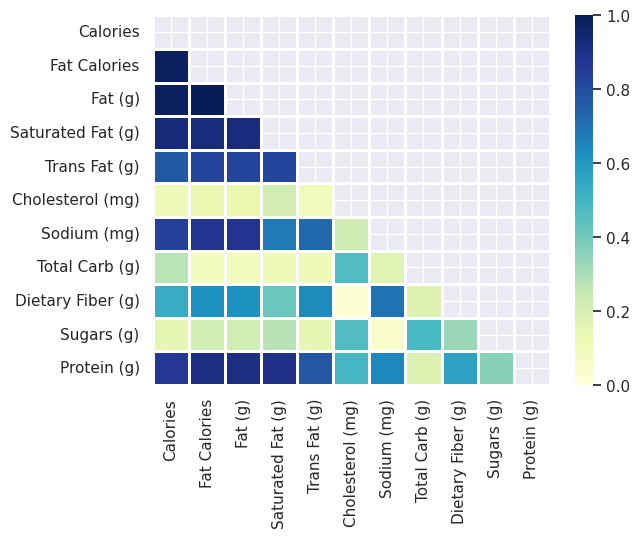

In [16]:
sns.heatmap(corr, mask=mask, vmin = 0.0, vmax = 1.0, linewidths = 1, cmap = "YlGnBu")
plt.show()

del corr
del mask

Función para reducir los combinaciones lineales

In [17]:
def reduce_lineal_combinations(dataset, n_drops=1):
  # Aplicamos una máscara NaN a todos las correlaciones superiores a .8 y menores a .3
  corr = dataset.corr().abs()
  corr = corr.mask(corr.gt(.8) | corr.lt(.3))

  # Se seleccionan los atributos a eliminar y se elimina arbitrariamente la mitad de estos atributos
  NaN_count = corr.isna().sum().sort_values(ascending=False)
  cols_to_drop = NaN_count[:n_drops].keys()

  for col in cols_to_drop:
    dataset = dataset.drop([col], axis=1)
    dataset = dataset.drop([col], axis=0)
    print("Dropped: %s" % col)
  return dataset

Quitamos todas los atributos con muy alta o muy baja correlación

In [18]:
clean_correlation_iters = None
while not clean_correlation_iters:
  try:
    clean_correlation_iters = int(
      input("Cuántas veces quieres limpiar las combinaciones lineales?\n>> ")
    )
  except ValueError: pass

for _ in range(0, 3):
  correlation_dataset = reduce_lineal_combinations(correlation_dataset)
correlation_dataset

Cuántas veces quieres limpiar las combinaciones lineales?
>> 4
Dropped: Fat Calories
Dropped: Fat (g)
Dropped: Calories


,Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carb (g),Dietary Fiber (g),Sugars (g),Protein (g)
Saturated Fat (g),1.000000,0.648116,0.335107,0.470210,0.454672,0.132336,0.137197,0.787295
Trans Fat (g),0.648116,1.000000,-0.012919,0.440154,0.131423,-0.143928,0.110322,0.656740
Cholesterol (mg),0.335107,-0.012919,1.000000,-0.081106,-0.016447,0.134475,-0.052707,0.611211
Sodium (mg),0.470210,0.440154,-0.081106,1.000000,0.301820,-0.246796,0.108017,0.495168
Total Carb (g),0.454672,0.131423,-0.016447,0.301820,1.000000,0.344996,0.480117,0.271513
Dietary Fiber (g),0.132336,-0.143928,0.134475,-0.246796,0.344996,1.000000,-0.162482,-0.084245
Sugars (g),0.137197,0.110322,-0.052707,0.108017,0.480117,-0.162482,1.000000,0.051508
Protein (g),0.787295,0.656740,0.611211,0.495168,0.271513,-0.084245,0.051508,1.000000


Se calcula nuevamente la matriz de correlación

In [19]:
# Obtener correlaciones de atributos usando correlación de pearson
corr = np.abs(correlation_dataset.corr())

# Genera máscara para el triángulo superior de la matriz
mask = np.zeros_like (corr, dtype = bool)
mask[np.triu_indices_from (mask)] = True


Se muestra la nueva matriz de correlación

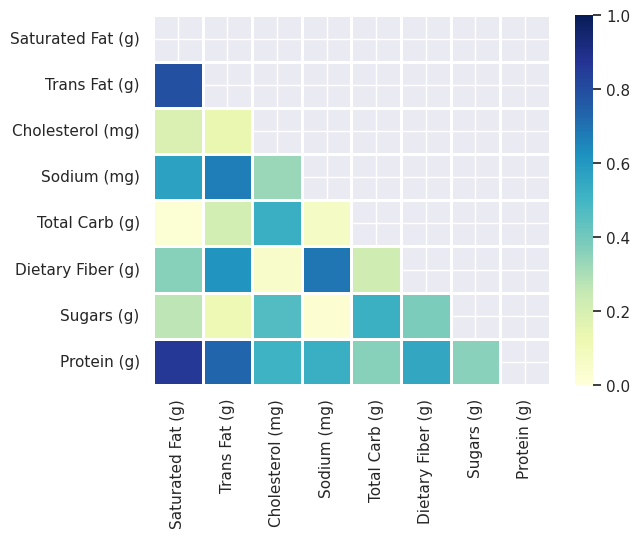

In [20]:
sns.heatmap (corr, mask=mask, vmin = 0.0, vmax = 1.0, linewidths = 1, cmap = "YlGnBu")
plt.show()

Con un valor de 3 iteraciones se logran limpiar todos los atributos que representan combinaciones lineales y aislamos a los componentes independientes

In [21]:
del correlation_dataset

## Explorando el dataset

Índice calórico general

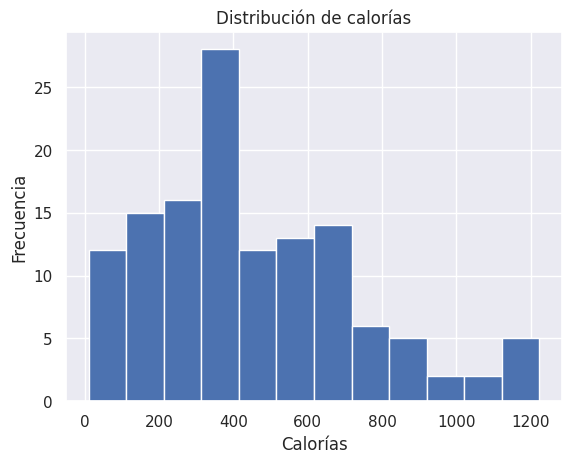

In [22]:
calories_hist_ax = bk_dataset['Calories'].plot.hist(bins=12)
calories_hist_ax.set_title("Distribución de calorías")
calories_hist_ax.set_xlabel("Calorías")
calories_hist_ax.set_ylabel("Frecuencia")
plt.show()

Comparación de parámetros de calorías, grasas y colesterol

### Cantidad de comidas según intervalos de 100 calorías

La mayor parte del menú de burger king aporta entre 200 y 400 calorías

In [23]:
nutritional_fields = ['Calories', 'Fat (g)', 'Total Carb (g)', 'Protein (g)']
nutritional_fields_dataset = bk_dataset[nutritional_fields].sort_values(['Calories']).reset_index()

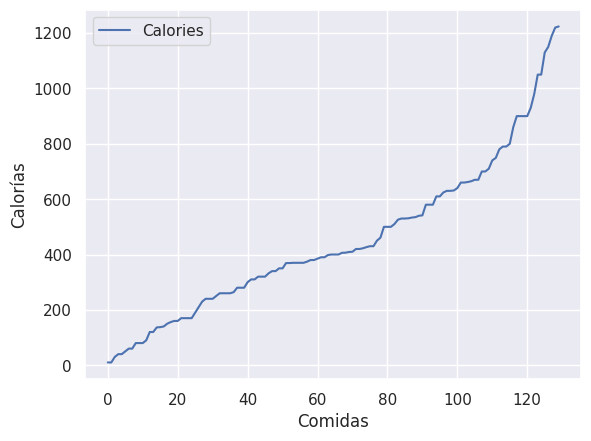

In [24]:
ax_cal_vs_fat = nutritional_fields_dataset['Calories'].plot(x=nutritional_fields_dataset.index, y='Calories')
ax_cal_vs_fat.legend(['Calories'])
ax_cal_vs_fat.set_xlabel("Comidas")
ax_cal_vs_fat.set_ylabel("Calorías")
plt.show()

### Grasas, carbohidratos y proteínas

Se puede observar que la actividad de las proteínas tienden a una relación de proporción inversas con las proteínas

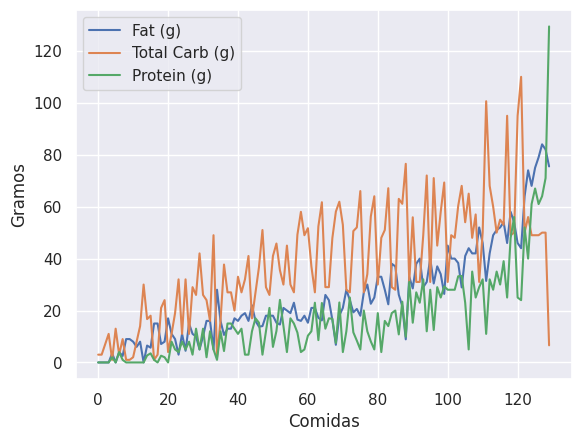

In [25]:
ax_fat_vs_carbs_vs_prot = nutritional_fields_dataset['Fat (g)'].plot()
nutritional_fields_dataset['Total Carb (g)'].plot()
nutritional_fields_dataset['Protein (g)'].plot()
ax_fat_vs_carbs_vs_prot.legend(['Fat (g)', 'Total Carb (g)', 'Protein (g)'])
ax_fat_vs_carbs_vs_prot.set_xlabel("Comidas")
ax_fat_vs_carbs_vs_prot.set_ylabel("Gramos")
plt.show()

### Cálculo de calorías de cada product vs calorías proveídas en el dataset

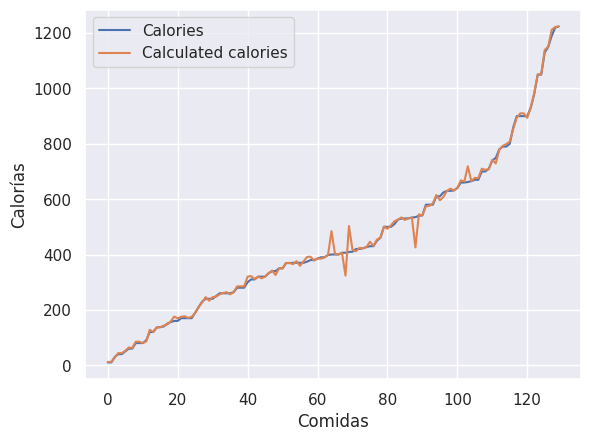

In [26]:
nutritional_fields_dataset['Calculated_calories'] = (
    (nutritional_fields_dataset['Total Carb (g)'] * 4) +
    (nutritional_fields_dataset['Protein (g)'] * 4) +
    (nutritional_fields_dataset['Fat (g)'] * 9)
)

ax_cals_vs_calc_cals = nutritional_fields_dataset['Calories'].plot()
nutritional_fields_dataset['Calculated_calories'].plot()
ax_cals_vs_calc_cals.legend(['Calories', 'Calculated calories'])
ax_cals_vs_calc_cals.set_xlabel("Comidas")
ax_cals_vs_calc_cals.set_ylabel("Calorías")
plt.show()

## Clasificando los productos que pueden provocar una tendencia a la hipertensión

La frecuencia con que se produce la hipertensión arterial y la hipercolesterolemia (colesterol alto) de manera conjunta es mayor entre la población hipertensa. Esto quiere decir que, si tienes la tensión alta, serás más propenso a presentar niveles más elevados de colesterol total.

Aunque el mejor tratamiento es una buena prevención para evitar su aparición, resulta imprescindible poner en marcha una serie de hábitos de vida saludables para controlar la presión arterial alta. Estos hábitos son:
* Dejar de fumar
* Moderar el consumo de alcohol
* Practicar regularmente ejercicio físico moderado (caminar, nadar o ir en bicicleta)
* <u>Mantener un peso adecuado</u>
* Seguir una dieta equilibrada y baja en sal
* Aumentar el consumo de alimentos ricos en fibra y potasio
* Reducir el consumo de bebidas con cafeína
* Evitar situaciones que provoquen estrés o ansiedad
* Practicar técnicas de relajación

https://www.ciad.mx/consumo-de-sodio-e-hipertension/
https://www.gob.mx/liconsa/articulos/etiquetado-enfoque-en-hipertension?idiom=es


## Clasificación de productos recomendados para personas hipertensas

**NOTA:** Existen productos que se venden como combo de piezas, por lo que no los contaremos debido a que agregan información innecesaria debido a la magnitud de su valor. Por eso vamos a eliminar a todos los que exadan el valor de la desviación estándar de la muestra 🥲

In [27]:
# Atributos de interés para ka clasificación
hipertension_dataset_attributes = ['Item', 'Cholesterol (mg)', 'Sodium (mg)']
hipertension_dataset = bk_dataset[hipertension_dataset_attributes]

chol_std = hipertension_dataset['Cholesterol (mg)'].std()
hipertension_dataset = hipertension_dataset[hipertension_dataset['Cholesterol (mg)'].lt(chol_std)]

hipertension_dataset_zipped = np.array(
    list(hipertension_dataset[hipertension_dataset_attributes[1:]].itertuples(index=False))
)

### Agrupando colesterol y sodio

In [28]:
# Se realiza el proceso de clustering usando DBSCAN
db_cluster = DBSCAN(eps=DB_SCAN_EPS, min_samples=DB_SCAN_MIN_SAMPLES).fit(hipertension_dataset_zipped)

labels = db_cluster.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Se encontraron %d clusters y hay %d nodos de ruido" % (n_clusters, n_noise))

Se encontraron 2 clusters y hay 7 nodos de ruido


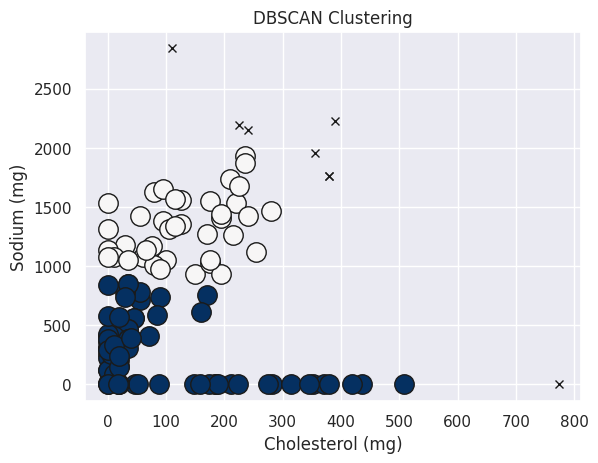

In [29]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db_cluster.core_sample_indices_] = True

colors = [plt.cm.RdBu_r(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    cluster_data = hipertension_dataset_zipped[class_member_mask & core_samples_mask]
    plt.plot(
        cluster_data[:, 0],
        cluster_data[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14
    )

    noise_data = hipertension_dataset_zipped[class_member_mask & ~core_samples_mask]
    plt.plot(
        noise_data[:, 0],
        noise_data[:, 1],
        "x",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6
    )

plt.title("DBSCAN Clustering")
plt.xlabel("Cholesterol (mg)")
plt.ylabel("Sodium (mg)")
plt.show()

### Monstrandos los alimentos menos dañinos para hipertensos


Comida clasificada

In [30]:
hipertension_dataset[core_samples_mask]

,Item,Cholesterol (mg),Sodium (mg)
0,American Cheese (slice),10.00,180.0
1,BBQ Bacon Crispy Chicken Sandwich,80.00,1630.0
2,BIG FISH Sandwich,30.00,1180.0
3,BK Grill,211.14,0.8
4,BK veggie,147.92,0.6
...,...,...,...
125,Whopper JR.® Sandwich,40.00,390.0
126,Whopper® Sandwich,90.00,980.0
127,Whopper® Sandwich with Cheese,115.00,1340.0
128,Xtra Long chicken,507.78,1.5


Comida menos dañina para hipertensos

In [31]:
hipertension_dataset[db_cluster.labels_ == 0]

,Item,Cholesterol (mg),Sodium (mg)
0,American Cheese (slice),10.00,180.0
3,BK Grill,211.14,0.8
4,BK veggie,147.92,0.6
8,Bacon Cheeseburger,55.00,710.0
9,Bacon Double Cheeseburger,90.00,740.0
...,...,...,...
123,Veg Whopper,345.40,1.6
124,Veg strips 3 Pcs,17.55,0.2
125,Whopper JR.® Sandwich,40.00,390.0
128,Xtra Long chicken,507.78,1.5


Comida más dañina para hipertensos

In [32]:
hipertension_dataset[db_cluster.labels_ == 1]

,Item,Cholesterol (mg),Sodium (mg)
1,BBQ Bacon Crispy Chicken Sandwich,80.0,1630.0
2,BIG FISH Sandwich,30.0,1180.0
6,Bacon & Cheese Crispy Chicken Sandwich,95.0,1650.0
7,Bacon & Cheese Whopper® Sandwich,125.0,1560.0
11,"Bacon, Egg & Cheese Biscuit",170.0,1270.0
13,Breakfast Burrito Jr.,150.0,930.0
19,"CROISSAN’WICH® Ham, Egg & Cheese",175.0,1030.0
20,"CROISSAN’WICH® Sausage, Egg & Cheese",195.0,930.0
22,Cheddar Bacon King Sandwich,235.0,1930.0
30,Chicken Nuggets- 20pc,115.0,1570.0
